In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow import keras
import statsmodels.api as sm
from math import sqrt
drive.mount('/content/drive')
df = pd.read_csv(r'/content/drive/MyDrive/Internship/latur_final.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def train_model(model, X_train, y_train):
    return model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)

def predict(model, X_test):
    return model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))

def train_arima(y_train):
    arima = sm.tsa.statespace.SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
    return arima.fit(disp=0)

def train_lstm(X_train, y_train, input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(50, activation='relu', input_shape=input_shape),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=23, batch_size=16, verbose=0)
    return model

def evaluate_metrics(y_test, y_pred):
    return {
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': sqrt(mean_squared_error(y_test, y_pred)),
        'r2': r2_score(y_test, y_pred)
    }

def plot_metrics(r2_score_value, residuals):
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.bar(['R^2'], [r2_score_value])
    plt.subplot(1, 3, 2)
    plt.scatter(final_prediction, residuals)
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=20)
    plt.tight_layout()
    plt.show()

In [ ]:
# Data pre-processing
X, y = df[['Rain', 'feed_temp']], df['SPEI']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1], 1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model initialization
ridge, svr, meta_learner = Ridge(), SVR(), RandomForestRegressor()
input_shape = (X_scaled.shape[1], 1)

In [ ]:
# Full Model training
trained_ridge = train_model(ridge, X_train, y_train)
trained_svr = train_model(svr, X_train, y_train)
trained_arima = train_arima(y_train)
trained_lstm = train_lstm(X_train, y_train, input_shape)

# Meta-features generation
meta_features_test = np.column_stack([predict(model, X_test) for model in [trained_ridge, trained_svr]])

# Meta-learner training
meta_learner.fit(meta_features_test, y_test)
final_prediction = meta_learner.predict(meta_features_test)

# Evaluation
metrics = evaluate_metrics(y_test, final_prediction)
print(f"Test Metrics: {metrics}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test Metrics: {'mse': 0.0032536832983694687, 'mae': 0.02125164321214467, 'rmse': 0.05704106677096308, 'r2': 0.9956735653724093}


In [ ]:
# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)
mse_list, mae_list, rmse_list, r2_list = [], [], [], []

# Time series cross-validation
for train_index, val_index in tscv.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Train individual models
    trained_ridge = train_model(ridge, X_train_fold, y_train_fold)
    trained_svr = train_model(svr, X_train_fold, y_train_fold)
    trained_arima = train_arima(y_train_fold)
    trained_lstm = train_lstm(X_train_fold, y_train_fold, input_shape)

    # Generate meta-features for validation set
    meta_features_val = np.column_stack([
        predict(model, X_val_fold) for model in [trained_ridge, trained_svr]
    ])
    y_pred_val_arima = trained_arima.predict(start=len(y_train_fold), end=len(y_train_fold) + len(y_val_fold) - 1, dynamic=False)
    y_pred_val_lstm = trained_lstm.predict(X_val_fold).flatten()

    meta_features_val = np.column_stack((meta_features_val, y_pred_val_arima, y_pred_val_lstm))

    # Train meta-learner on validation set
    meta_learner.fit(meta_features_val, y_val_fold)

    # Generate final ensemble predictions on validation set
    final_prediction = meta_learner.predict(meta_features_val)

    # Evaluation
    metrics = evaluate_metrics(y_val_fold, final_prediction)

    # Append to lists
    mse_list.append(metrics['mse'])
    mae_list.append(metrics['mae'])
    rmse_list.append(metrics['rmse'])
    r2_list.append(metrics['r2'])

# Calculate and print average metrics
print('Time series cross val based metrics: ')
average_metrics = {
    'Average MSE': np.mean(mse_list),
    'Average MAE': np.mean(mae_list),
    'Average RMSE': np.mean(rmse_list),
    'Average R-squared': np.mean(r2_list)
}
print(f"Average Metrics: {average_metrics}")

3/3 [==============================] - 0s 5ms/step
Time series cross val based metrics: 
Average Metrics: {'Average MSE': 0.0021624933290446055, 'Average MAE': 0.02364215215745927, 'Average RMSE': 0.044935739733032935, 'Average R-squared': 0.9978800675682479}


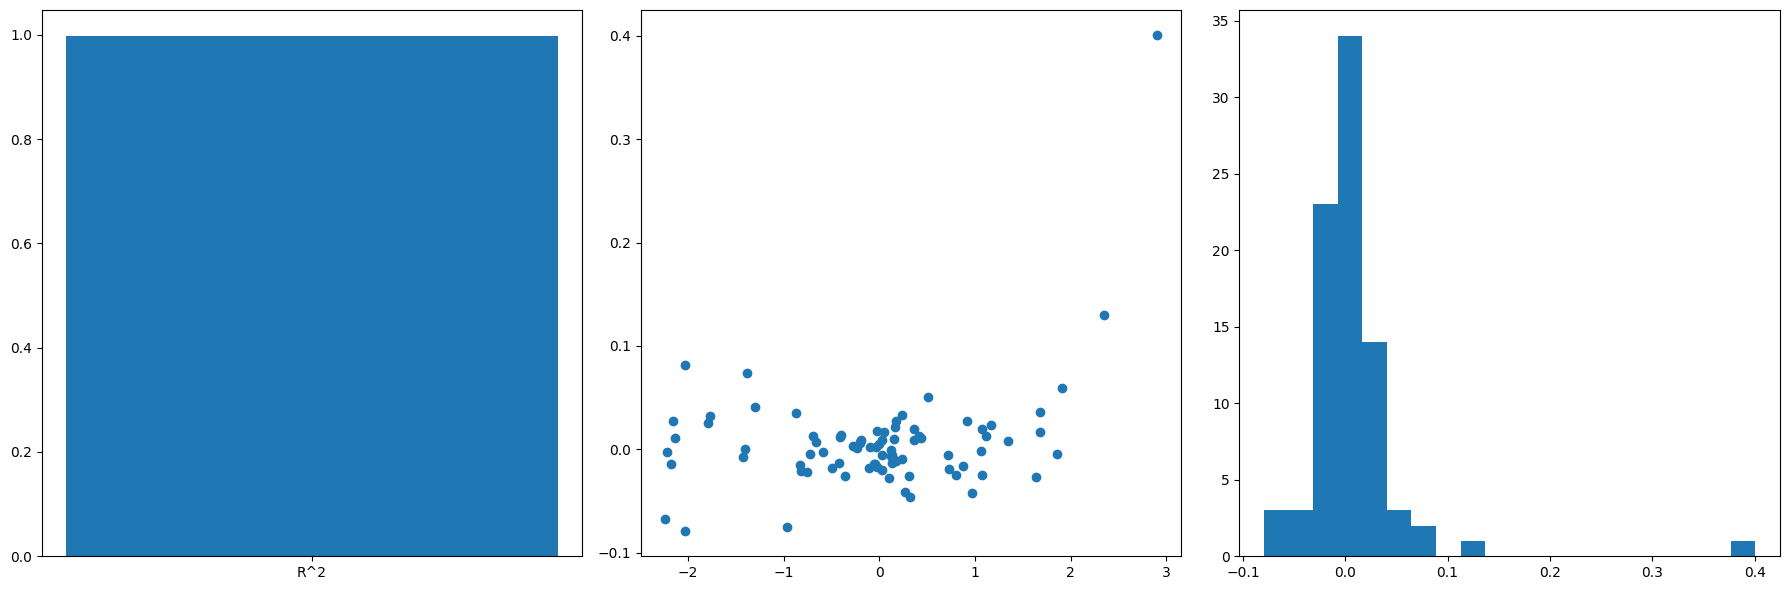

In [ ]:
# Visualization
residuals = y_val_fold - final_prediction
r2_score_value = r2_score(y_val_fold, final_prediction)
plot_metrics(r2_score_value, residuals)